In [32]:
import io
from typing import Tuple

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf

from evojax.task.base import TaskState
from flax.struct import dataclass
from jax import random
from PIL import Image

from train import get_task

import json
import os
import shutil
from datetime import datetime
from pathlib import Path

import hydra
import jax
import jax.tree_util
from evojax import util
from evojax.task.slimevolley import SlimeVolley
from omegaconf import DictConfig, OmegaConf

from neat.algo.genome import ActivationFunction
from neat.algo.neat import NEAT
from neat.policy import NEATPolicy
from neat.sim_mgr import monkey_duplicate_params
from neat.task import XOR, Circle, Spiral
from neat.trainer import NEATTrainer, load_model

In [33]:
def render_saliency_map(obs, labels, policy_action_fn, blending_aggressiveness=0.5):
    """
    Renders a saliency map with adjustable color blending aggressiveness.

    Args:
        obs (np.array): The ground truth observations.
        labels (np.array): The ground truth labels.
        policy_action_fn (callable): A function that returns policy logits for given observations.
        blending_aggressiveness (float): Controls color intensity. Values < 1.0 increase
                                         saturation, 1.0 is linear, > 1.0 increases whiteness.
    """
    plt.figure(figsize=(8, 8))

    # Create a grid of points to cover the observation space
    x_min, x_max = obs[:, 0].min() - 0.5, obs[:, 0].max() + 0.5
    y_min, y_max = obs[:, 1].min() - 0.5, obs[:, 1].max() + 0.5
    resolution = 150
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))

    # Query the policy for each point on the grid to find the decision boundary
    grid_points = jnp.c_[xx.ravel(), yy.ravel()]
    # The provided policy_action_fn is used here to get predictions for the grid
    grid_predictions = policy_action_fn(grid_points)

    # Calculate logit difference to determine color intensity
    logits_class_0 = grid_predictions[:, 0]
    logits_class_1 = grid_predictions[:, 1]
    diff_logits = np.abs(logits_class_1 - logits_class_0)

    # Normalize the difference to a [0, 1] range for blending
    min_diff, max_diff = diff_logits.min(), diff_logits.max()
    norm_diff = (diff_logits - min_diff) / (max_diff - min_diff + 1e-8)

    # Apply the aggressiveness factor to the blend ratio
    # This non-linear adjustment increases color contrast[3]
    blend_factor = (norm_diff ** blending_aggressiveness)[:, np.newaxis]

    # Create an RGB color grid for plotting
    orange = np.array([232 / 255, 175 / 255, 108 / 255])  # RGB for orange
    blue = np.array([86 / 255, 146 / 255, 185 / 255])  # RGB for blue
    white = np.array([1.0, 1.0, 1.0])

    is_class_1_dominant = logits_class_1 > logits_class_0
    base_colors = np.where(is_class_1_dominant[:, np.newaxis], blue, orange)

    # Blend base color with white based on the adjusted blend_factor
    # This is a form of manual alpha compositing[5]
    color_grid = blend_factor * base_colors + (1 - blend_factor) * white
    color_grid_reshaped = color_grid.reshape((resolution, resolution, 3))

    # Plot the color grid and the ground truth points
    plt.imshow(color_grid_reshaped, extent=(x_min, x_max, y_min, y_max), origin="lower", alpha=0.9)

    plt.plot(
        obs[labels == 0, 0], obs[labels == 0, 1], "o", label="Class 0", ms=6, color="#E8AF6C", markeredgecolor="white"
    )
    plt.plot(
        obs[labels == 1, 0], obs[labels == 1, 1], "o", label="Class 1", ms=6, color="#5692B9", markeredgecolor="white"
    )

    # Finalize the plot and convert to a PIL Image
    plt.title("Two-Color Intensity of Model Output vs. Ground Truth")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches="tight")
    plt.close()
    buf.seek(0)

    return Image.open(buf)

In [34]:
output_dir = "/home/bartek/Workspace/ideas/NEAT/results/2025-06-07_18-28-03_xor"
config = OmegaConf.load(f"{output_dir}/config.yaml")

In [35]:
policy = NEATPolicy()
train_task = get_task(config, test=False)
test_task = get_task(config, test=True)
solver = NEAT(
    pop_size=config.neat.pop_size,
    num_inputs=train_task.obs_shape[0],
    num_outputs=train_task.act_shape[0],
    survival_threshold=config.neat.survival_threshold,
    compatibility_threshold=config.neat.compatibility_threshold,
    c1=config.neat.c1,
    c2=config.neat.c2,
    c3=config.neat.c3,
    prob_add_node=config.neat.prob_add_node,
    prob_add_connection=config.neat.prob_add_connection,
    max_stagnation=config.neat.max_stagnation,
    activation_function=config.neat.activation_function,
    last_activation_function=config.neat.last_activation_function,
    logger=None,
    seed=config.eval.seed,
    log_dir=output_dir,
)

# Train.
trainer = NEATTrainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=config.trainer.max_iter,
    log_interval=config.trainer.log_interval,
    test_interval=config.trainer.test_interval,
    n_repeats=config.trainer.n_repeats,
    n_evaluations=config.trainer.n_evaluations,
    seed=config.eval.seed,
    log_dir=output_dir,
    use_backprop=config.trainer.use_backprop,
    backprop_steps=config.trainer.backprop_steps,
    learning_rate=config.trainer.learning_rate,
    l2_penalty=config.trainer.l2_penalty,
    complexity_penalty=config.trainer.complexity_penalty,
    optimizer=config.trainer.optimizer,
    logger=None,
)

Trainer: 2025-06-07 18:45:10,983 [INFO] use_for_loop=False


In [36]:
trainer.model_dir = output_dir
trainer.run(demo_mode=True)

Trainer: 2025-06-07 18:45:11,021 [INFO] Loaded model parameters from /home/bartek/Workspace/ideas/NEAT/results/2025-06-07_18-28-03_xor.
Trainer: 2025-06-07 18:45:11,022 [INFO] Start to test the parameters.
Trainer: 2025-06-07 18:45:11,649 [INFO] [TEST] #tests=1, max=0.9834, avg=0.9834, min=0.9834, std=0.0000


np.float32(0.98339844)

In [37]:
# Visualize the policy.
task_reset_fn = jax.jit(test_task.reset)
policy_reset_fn = jax.jit(policy.reset)
step_fn = jax.jit(test_task.step)
action_fn = jax.jit(policy.get_actions)

best_params, obs_params = load_model(model_dir=output_dir)
best_params = monkey_duplicate_params(best_params, 1, False, True)
key = jax.random.PRNGKey(0)[None, :]

task_state = task_reset_fn(key)
policy_state = policy_reset_fn(task_state)
screens = []
for _ in range(test_task.max_steps):
    action, policy_state = action_fn(task_state, best_params, policy_state)
    task_state, reward, done = step_fn(task_state, action)

    # Extract the single state from the batched task_state
    current_unbatched_state = jax.tree_util.tree_map(lambda x: x[0], task_state)
    if config.task.name == "slimevolley":
        screens.append(SlimeVolley.render(current_unbatched_state))
    else:

        def policy_action_for_viz(obs):
            dummy_policy_state = policy_reset_fn(task_state)
            actions, _ = policy.get_actions(
                jax.tree_util.tree_map(lambda x: obs, task_state), best_params, dummy_policy_state
            )
            return actions

        screens.append(
            render_saliency_map(
                current_unbatched_state.obs,
                current_unbatched_state.labels,
                policy_action_for_viz,
                blending_aggressiveness=0.5,
            )
        )

gif_file = os.path.join(output_dir, f"{config.task.name}.gif")
screens[0].save(gif_file, save_all=True, append_images=screens[1:], duration=40, loop=0)

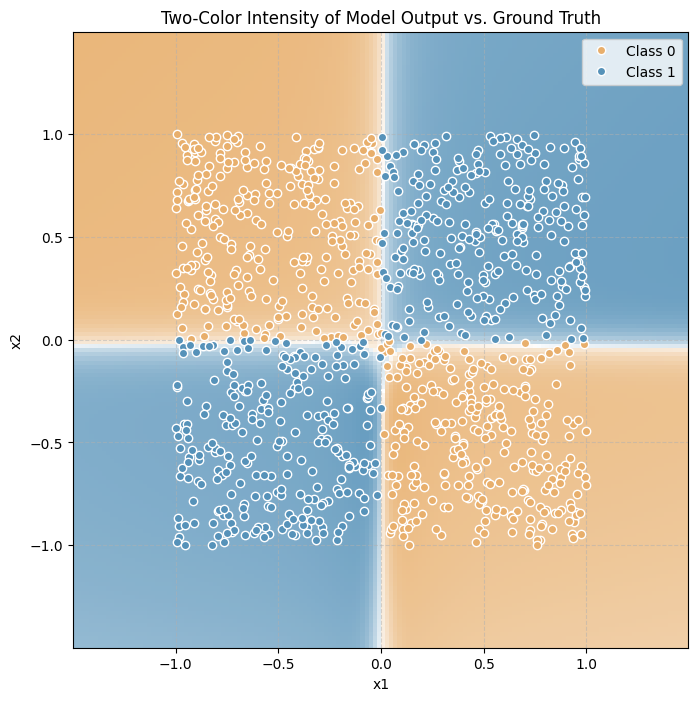

In [38]:
screens[0]